# Homework 1: Aircraft inventory analysis

In this homework, we will explore the aircraft inventory dataset from 2006 to 2023 (Source: Bureau of Transportation Statistics, www.bts.gov).  

**Some useful resources:**
- You may find explanation of the dataset attributes available in [BTS dataset attribute summary](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=GEH).
- You may verify some of your analyses by comparing your results with the BTS analysis dashboard.  The dashboard is reachable via the "Analysis" column in the attribute summary linked above.

**General rules of thumb for homeworks:**
- Read the homework questions carefully.
- Explain your choices.
- Present your findings concisely.
- Use tables, plots, and summary statistics to aid your presentation of findings.
- If you have an idea in mind but could not implement (in code), present the idea thoroughly and how you would have implemented the code.

### Tasks:

For all tasks below, create one or more functions for any systematic changes to the dataset.  For instance, someone could run the sequence of functions to transform the dataset.

Specify the sequence of functions.

1. Investigate the missing data in this dataset. Specifically, for each of the following variables that have missing data, decide if any imputation is possible.  Give your reasoning and code for how you decide to impute missing values.  
    - Columns for investigation: `CARRIER`, `CARRIER_NAME`, `MANUFACTURE_YEAR`, `NUMBER_OF_SEATS`, `CAPACITY_IN_POUNDS`, and `AIRLINE_ID`.
    - For example, watch out for "North American Airlines" aircrafts.  Are the `CARRIER`/`UNIQUE_CARRIER` column *really* missing?

2. Inspect the columns `MANUFACTURER`, `MODEL`, `AIRCRAFT_STATUS`, and `OPERATING_STATUS`.  Decide, for each column, if transformation or standardization of data are required.  Give your reasoning and code if you decide to transform the data.  

    **Hints:**
    - For very messy data like manufacturer/model names, give your best attempt. It is okay to not catch them all.
    - Use `value_counts()` to identify "big wins".
    - Break down into multiple steps, instead of having one line of code to do them all.

3. Remove data rows that still have missing values.  Report the amount of remaining data you obtained.

4. Transformation and derivative variables
   - For the columns `NUMBER_OF_SEATS` and `CAPACITY_IN_POUNDS`, check the skewness in the variable and plot a histogram for each variable.
   - The Box-Cox transformation (`scipy.stats.boxcox`) is one possible way to transform variables into a "more-normal-like" variable.  Apply the Box-Cox transformation for these two columns and save them as new columns, i.e. `XXXXXXXXX_BOXCOX`.
   - Plot a histogram for each transformed variable.
   - Describe what you observe before and after transformation.

5. Feature engineering
    - Create a new column `SIZE` by the quartiles of `NUMBER_OF_SEATS`
        - below 25% percentile: `SMALL`
        - 25% - 50% percentile: `MEDIUM`
        - 50% - 75% percentile: `LARGE`
        - above 75% percentile: `XLARGE`
    - For each size group, provide and plot the proportions of aircrafts that are operating versus not (`OPERATING_STATUS`).
    - For each size group, provide and plot the proportions of aircrafts belonging to each aircraft status group (`AIRCRAFT_STATUS`).
    - Provide a written summary of your findings.

### Dataset (imports and preliminary EDA)
You may read in the dataset with the following code.  Otherwise, you can find the [dataset](https://github.com/mosesyhc/de300-2026wi/raw/refs/heads/main/datasets/T_F41SCHEDULE_B43.zip) available in the `dataset` directory.  *Note* that `pandas.read_csv()` is capable of reading a zipped .csv file and no unzipping is required.

In [26]:
import pandas as pd
inventory = pd.read_csv('/content/T_F41SCHEDULE_B43.zip')
inventory_backup = inventory.copy()

/tmp/ipython-input-2564840572.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 132313 non-null  int64  
 1   CARRIER              132264 non-null  object 
 2   CARRIER_NAME         132208 non-null  object 
 3   MANUFACTURE_YEAR     132310 non-null  float64
 4   UNIQUE_CARRIER_NAME  132208 non-null  object 
 5   SERIAL_NUMBER        132313 non-null  object 
 6   TAIL_NUMBER          132313 non-null  object 
 7   AIRCRAFT_STATUS      132313 non-null  object 
 8   OPERATING_STATUS     132313 non-null  object 
 9   NUMBER_OF_SEATS      132306 non-null  float64
 10  MANUFACTURER         132313 non-null  object 
 11  AIRCRAFT_TYPE        102380 non-null  object 
 12  MODEL                132302 non-null  object 
 13  CAPACITY_IN_POUNDS   132212 non-null  float64
 14  ACQUISITION_DATE     131346 non-null  object 
 15  AIRLINE_ID       

In [4]:
inventory.head()

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
0,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7858,N202PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,10/28/2003 12:00:00 AM,20397.0,16
1,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7860,N206PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,10/30/2003 12:00:00 AM,20397.0,16
2,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7873,N207PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,11/26/2003 12:00:00 AM,20397.0,16
3,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7874,N209PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,12/4/2003 12:00:00 AM,20397.0,16
4,2006,16,PSA Airlines Inc.,2003.0,PSA Airlines Inc.,7879,N213PS,B,Y,50.0,CANADAIR,NaN,CRJ-2/4,47000.0,12/16/2003 12:00:00 AM,20397.0,16


In [5]:
!pip install miceforest

In [6]:
# Imports
import missingno as msno
import miceforest as mf
import plotnine
from sklearn.impute import KNNImputer, SimpleImputer

In [7]:
# Missing data overview
missing_cols = ['CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR', 'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID']

missing_summary = inventory[missing_cols].isna().mean().sort_values(ascending=False)
missing_summary

,0
CARRIER_NAME,0.000794
AIRLINE_ID,0.000794
CAPACITY_IN_POUNDS,0.000763
CARRIER,0.000370
NUMBER_OF_SEATS,0.000053
MANUFACTURE_YEAR,0.000023


<Axes: >

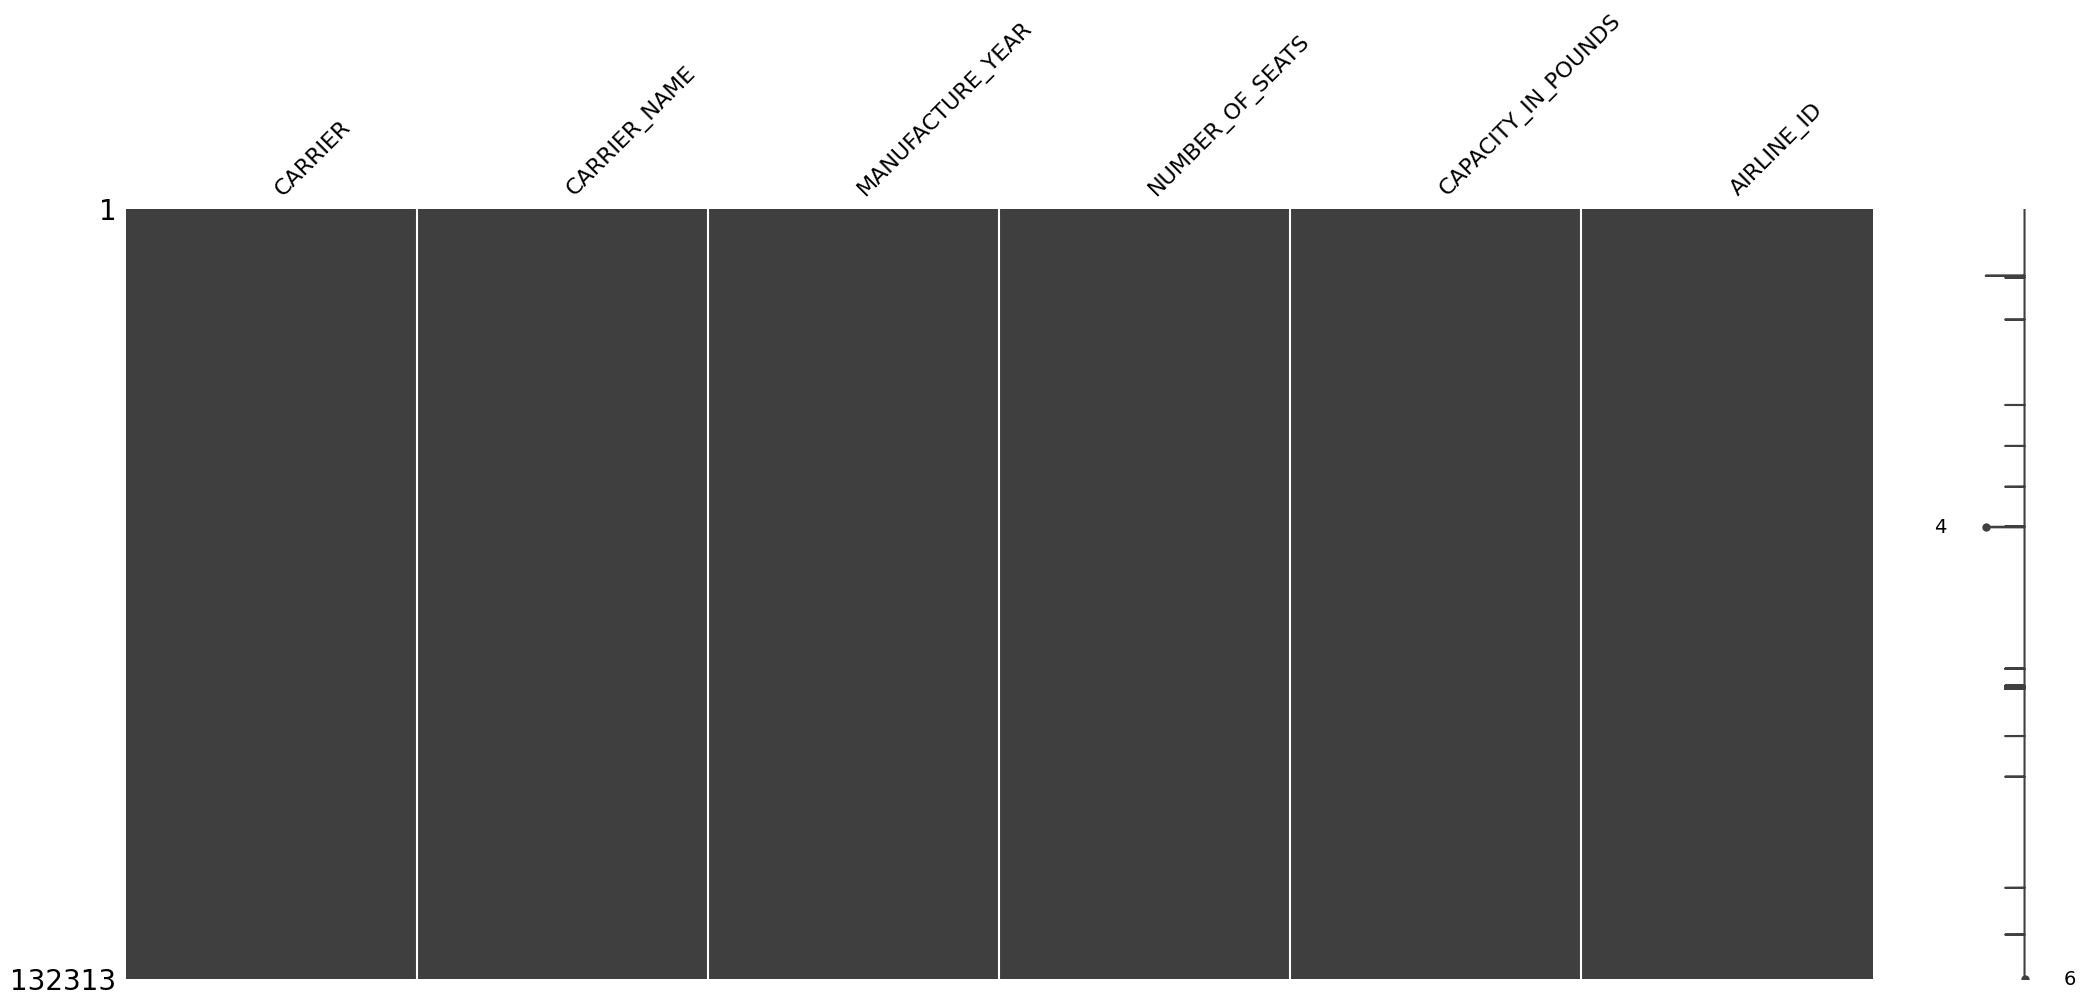

In [8]:
msno.matrix(inventory[missing_cols])

In [13]:
missing_counts = inventory[missing_cols].isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)


CARRIER_NAME          105
AIRLINE_ID            105
CAPACITY_IN_POUNDS    101
CARRIER                49
NUMBER_OF_SEATS         7
MANUFACTURE_YEAR        3
dtype: int64


### Tasks

#### CARRIER_NAME and AIRLINE_ID (EDA)

In [27]:
inventory.assign(
  carrier_name_missing=inventory["CARRIER_NAME"].isna(),
  airline_id_missing=inventory["AIRLINE_ID"].isna()
)[["carrier_name_missing", "airline_id_missing"]].value_counts()

# Every row that is missing carrier_name is also missing airline_id


,,count
carrier_name_missing,airline_id_missing,
False,False,132208
True,True,105


In [55]:
inventory.loc[
  inventory["AIRLINE_ID"].isna(),
  ["CARRIER", "CARRIER_NAME", "UNIQUE_CARRIER_NAME"]
].drop_duplicates()
# All missing CARRIER_NAME are either L4 or OH

,CARRIER,CARRIER_NAME,UNIQUE_CARRIER_NAME
11465,L4,NaN,NaN
54610,OH,NaN,NaN


In [53]:
inventory.loc[
  inventory["CARRIER"] == "L4",
  ["CARRIER", "CARRIER_NAME", "UNIQUE_CARRIER_NAME", "AIRLINE_ID", "MODEL", "SERIAL_NUMBER"]
]
# L4 can be imputed directly to Lynx

,CARRIER,CARRIER_NAME,UNIQUE_CARRIER_NAME,AIRLINE_ID,MODEL,SERIAL_NUMBER
11465,L4,NaN,NaN,NaN,DASH8-Q4,4165
11466,L4,NaN,NaN,NaN,DASH8-Q4,4168
11467,L4,NaN,NaN,NaN,DASH8-Q4,4170
11468,L4,NaN,NaN,NaN,DASH8-Q4,4172
11469,L4,NaN,NaN,NaN,DASH8-Q4,4174
11470,L4,NaN,NaN,NaN,DASH8-Q4,4176
11471,L4,NaN,NaN,NaN,DASH8-Q4,4181
11472,L4,NaN,NaN,NaN,DASH8-Q4,4182
18739,L4,Lynx Aviation d/b/a Frontier Airlines,Lynx Aviation d/b/a Frontier Airlines,21217.0,DASH8-Q4,4165
18740,L4,Lynx Aviation d/b/a Frontier Airlines,Lynx Aviation d/b/a Frontier Airlines,21217.0,DASH8-Q4,4168


In [52]:
oh_missing_models = inventory.loc[
  (inventory["CARRIER"] == "OH") &
  (inventory["CARRIER_NAME"].isna()),
  "MODEL"
].dropna().unique()

print(oh_missing_models)

# All models for OH missing Carrier_name are Passanger series

['CRJ100-Passanger' 'CRJ200-Passanger' 'CRJ700-Passanger'
 'CRJ900-Passanger']


In [38]:
inventory.loc[
  inventory["CARRIER"] == "OH", "CARRIER_NAME"
].dropna().unique()

# OH is either Comair or PSA

array(['Comair Inc.', 'PSA Airlines Inc.'], dtype=object)

In [48]:
inventory.loc[
  inventory["CARRIER_NAME"].isin(["Comair Inc.", "PSA Airlines Inc."]),
  ["CARRIER_NAME", "MODEL"]
].dropna().drop_duplicates().sort_values(["CARRIER_NAME", "MODEL"])

# Comair Uses models with "Passanger", PSA does not, so OH can be imputed to Comair

,CARRIER_NAME,MODEL
4999,Comair Inc.,CRJ-2/4
12384,Comair Inc.,CRJ-900
33726,Comair Inc.,CRJ100-Passanger
33792,Comair Inc.,CRJ200-Passanger
33796,Comair Inc.,CRJ700-Passanger
33813,Comair Inc.,CRJ900-Passanger
26653,Comair Inc.,RJ-200
5002,Comair Inc.,RJ-700
26657,Comair Inc.,RJ-700
26674,Comair Inc.,RJ-900


In [56]:
inventory.loc[
  inventory["CARRIER_NAME"] == "Comair Inc.", "AIRLINE_ID"
].dropna().unique()

array([20417.])

In [58]:
inventory.loc[
  inventory["CARRIER_NAME"] == "Lynx Aviation d/b/a Frontier Airlines", "AIRLINE_ID"
].dropna().unique()
# Just to confirm, each carrier name is 1:1 with a airline id

array([21217.])

#### CARRIER (EDA)

In [62]:
# Show unique carrier_names if carrier is missing
inventory.loc[
  inventory["CARRIER"].isna(),
  "CARRIER_NAME"
].dropna().unique()

array(['North American Airlines'], dtype=object)

In [70]:
# Show rows where North American Airlines is Carrier_name and carrier is missing
inventory.loc[
  (inventory["CARRIER_NAME"] == "North American Airlines")]

# There's a real possibility that the Carrier was mistakenly entered as NaN instead of NA

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
11776,2007,NaN,North American Airlines,1993.0,North American Airlines,26257,N760NA,B,Y,273.0,BOEING,NaN,B767-3,104476.0,3/23/2004 12:00:00 AM,20415.0,NaN
11777,2007,NaN,North American Airlines,1995.0,North American Airlines,26277,N750NA,B,Y,199.0,BOEING,NaN,B757-2,58491.0,1/27/1995 12:00:00 AM,20415.0,NaN
11778,2007,NaN,North American Airlines,1996.0,North American Airlines,28039,N769NA,B,Y,268.0,BOEING,NaN,B767-3,100500.0,2/19/2007 12:00:00 AM,20415.0,NaN
11779,2007,NaN,North American Airlines,1996.0,North American Airlines,28098,N765NA,B,Y,206.0,BOEING,NaN,B767-3,94523.0,3/23/2006 12:00:00 AM,20415.0,NaN
11780,2007,NaN,North American Airlines,1997.0,North American Airlines,28174,N752NA,B,Y,199.0,BOEING,NaN,B757-2,58948.0,5/12/1999 12:00:00 AM,20415.0,NaN
11781,2007,NaN,North American Airlines,2000.0,North American Airlines,30043,N755NA,B,Y,199.0,BOEING,NaN,B757-2,56526.0,2/25/2003 12:00:00 AM,20415.0,NaN
11782,2007,NaN,North American Airlines,2001.0,North American Airlines,29381,N754NA,B,Y,199.0,BOEING,NaN,B757-2,58550.0,4/2/2001 12:00:00 AM,20415.0,NaN
11783,2007,NaN,North American Airlines,2001.0,North American Airlines,32448,N756NA,B,Y,199.0,BOEING,NaN,B757-2,58159.0,6/3/2001 12:00:00 AM,20415.0,NaN
11784,2007,NaN,North American Airlines,2002.0,North American Airlines,27569,N767NA,B,Y,247.0,BOEING,NaN,B767-3,105420.0,8/14/2002 12:00:00 AM,20415.0,NaN
11785,2007,NaN,North American Airlines,2002.0,North American Airlines,29898,N768NA,B,Y,262.0,BOEING,NaN,B767-3,103057.0,9/6/2002 12:00:00 AM,20415.0,NaN


#### MANUFACTURE_YEAR (EDA)

In [71]:
# print rows where MANUFACTURE_YEAR is missing
inventory.loc[
  inventory["MANUFACTURE_YEAR"].isna()
]

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,NaN,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,8192,B747-400,0.0,1/25/2022 12:00:00 AM,20007.0,5Y
124680,2023,9E,Endeavor Air Inc.,NaN,Endeavor Air Inc.,10134,N655CA,O,Y,69.0,BOMBARDIER,6311,CL-600-2C10,18055.0,NaN,20363.0,9E
124681,2023,9E,Endeavor Air Inc.,NaN,Endeavor Air Inc.,10182,N690CA,O,N,69.0,BOMBARDIER,6311,CL-600-2C10,18055.0,NaN,20363.0,9E


In [ ]:
# print rows with serial numbers 10134
inventory.loc[
  inventory["SERIAL_NUMBER"] == "10134"
]
# its 2004

In [ ]:
# print rows with serial number 10182
inventory.loc[
  inventory["SERIAL_NUMBER"] == "10182"
]
# Also 2004

In [77]:
# print rows with serial number 26259
inventory.loc[
  inventory["SERIAL_NUMBER"] == "26259"
]
# only record with this serial number

,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,NaN,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,8192,B747-400,0.0,1/25/2022 12:00:00 AM,20007.0,5Y


In [84]:
inventory.loc[inventory["MODEL"] == "B747-400", "MANUFACTURE_YEAR"].describe()
# Average is 2000, but high range - not safe to impute by model

,MANUFACTURE_YEAR
count,362.000000
mean,1999.168508
std,4.094020
min,1989.000000
25%,1998.000000
50%,2000.000000
75%,2001.000000
max,2021.000000


In [98]:
# Print rows with similar serial number, model, and carrier name
numeric_serials = inventory[inventory["SERIAL_NUMBER"].str.isnumeric()]
numeric_serials["SERIAL_NUMBER_INT"] = numeric_serials["SERIAL_NUMBER"].astype(int)

result = numeric_serials.loc[
  (numeric_serials["CARRIER_NAME"] == "Atlas Air Inc.") &
  (numeric_serials["SERIAL_NUMBER_INT"] >= 26259 - 100) &
  (numeric_serials["SERIAL_NUMBER_INT"] <= 26259 + 100),
  ["SERIAL_NUMBER", "SERIAL_NUMBER_INT", "MODEL", "CARRIER_NAME", "MANUFACTURE_YEAR"]
].sort_values("SERIAL_NUMBER_INT")

print(result)

# Lists all serial numbers close to the 26259 from Atlas Air Inc. Assumes some
# sequence in serial numbers. All B747s in this range were manufactuerd in 1992, so
# the manufactured year will be set to 1992.



       SERIAL_NUMBER  SERIAL_NUMBER_INT       MODEL    CARRIER_NAME  \
93621          26206              26206  B767-300ER  Atlas Air Inc.   
124540         26206              26206  B767-300ER  Atlas Air Inc.   
116663         26206              26206  B767-300ER  Atlas Air Inc.   
101007         26206              26206  B767-300ER  Atlas Air Inc.   
64709          26207              26207  B767-300ER  Atlas Air Inc.   
43851          26207              26207           0  Atlas Air Inc.   
57686          26207              26207  B767-300ER  Atlas Air Inc.   
50721          26207              26207  B767-300ER  Atlas Air Inc.   
93623          26208              26208  B767-300ER  Atlas Air Inc.   
101009         26208              26208  B767-300ER  Atlas Air Inc.   
124542         26208              26208  B767-300ER  Atlas Air Inc.   
116665         26208              26208  B767-300ER  Atlas Air Inc.   
86341          26208              26208  B767-300ER  Atlas Air Inc.   
116651

/tmp/ipython-input-3959650851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### NUMBER_OF_SEATS and CAPACITY_IN_POUNDS (EDA)

In [103]:
# Select rows with missing number of seats
missing_seats_rows = inventory.loc[inventory["MODEL"]=='767-338ERCARGO']
print(missing_seats_rows)

# All rows with missing number of seats are cargo models. There seems to be
# inconsistency in whether these are entered as 0 or NaN. All entries can be
# imputed to 0.




        YEAR CARRIER            CARRIER_NAME  MANUFACTURE_YEAR  \
61296   2014      M6  Amerijet International            1988.0   
61297   2014      M6  Amerijet International            1988.0   
68641   2015      M6  Amerijet International            1988.0   
68642   2015      M6  Amerijet International            1988.0   
75743   2016      M6  Amerijet International            1988.0   
75744   2016      M6  Amerijet International            1988.0   
75745   2016      M6  Amerijet International            1990.0   
82884   2017      M6  Amerijet International            1988.0   
82885   2017      M6  Amerijet International            1988.0   
82886   2017      M6  Amerijet International            1990.0   
82887   2017      M6  Amerijet International            1991.0   
90248   2018      M6  Amerijet International            1988.0   
90249   2018      M6  Amerijet International            1988.0   
90250   2018      M6  Amerijet International            1990.0   
97551   20

In [149]:
# Check if capacity can be imputed by model
missing_capacity_models = inventory.loc[inventory["CAPACITY_IN_POUNDS"].isna(), "MODEL"].unique()

for model in missing_capacity_models:
  # get all rows with this model and non-missing, non-zero capacity
  capacities = inventory.loc[
      (inventory["MODEL"] == model) &
      (inventory["CAPACITY_IN_POUNDS"].notna()) &
      (inventory["CAPACITY_IN_POUNDS"] > 0),
      "CAPACITY_IN_POUNDS"
  ]

# Some, but not all rows missing capacity have necessary data elsewhere in df - better to use numerical imputation

#### Problem 1 Function

In [158]:
def impute_missing(df):
  # deterministically impute CARRIER_NAME and AIRLINE_ID
  mask_L4 = (df["CARRIER"] == "L4") & (df["CARRIER_NAME"].isna())
  df.loc[mask_L4, "CARRIER_NAME"] = "Lynx Aviation d/b/a Frontier Airlines"
  df.loc[mask_L4, "AIRLINE_ID"] = 21217

  mask_OH = (df["CARRIER"] == "OH") & (df["CARRIER_NAME"].isna())
  df.loc[mask_OH, "CARRIER_NAME"] = "Comair Inc."
  df.loc[mask_OH, "AIRLINE_ID"] = 21417

  # correct potential error in Carrier entry for NA Airlines
  mask_NA = (df["CARRIER"].isna()) & (df["CARRIER_NAME"]=='North American Airlines')
  df.loc[mask_NA, "CARRIER"] = "NA"

  # deterministically impute MANUFACTURE_YEAR
  mask_MY1 = (df["MANUFACTURE_YEAR"].isna()) & (df["SERIAL_NUMBER"] == "26259")
  df.loc[mask_MY1, "MANUFACTURE_YEAR"] = 1992
  mask_MY2 = (df["MANUFACTURE_YEAR"].isna()) & (df["SERIAL_NUMBER"] == "10134")
  df.loc[mask_MY2, "MANUFACTURE_YEAR"] = 2004
  mask_MY3 = (df["MANUFACTURE_YEAR"].isna()) & (df["SERIAL_NUMBER"] == "10182")
  df.loc[mask_MY3, "MANUFACTURE_YEAR"] = 2004

  # impute missing number of seats with 0
  df["NUMBER_OF_SEATS"] = df["NUMBER_OF_SEATS"].fillna(0)

  # Use KNN to impute capacity in pounds
  knn_features = df[["NUMBER_OF_SEATS", "MANUFACTURE_YEAR", "CAPACITY_IN_POUNDS"]].copy()
  knn_features["CAPACITY_IN_POUNDS"].replace(0, pd.NA, inplace=True)

  imputer = KNNImputer(n_neighbors= 7, weights="distance")
  knn_imputed = imputer.fit_transform(knn_features)

  df["CAPACITY_IN_POUNDS"] = knn_imputed[:, 2]



  return df


In [159]:
inventory_imputed = impute_missing(inventory)
inventory_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132313 entries, 0 to 132312
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   YEAR                 132313 non-null  int64         
 1   CARRIER              132313 non-null  object        
 2   CARRIER_NAME         132313 non-null  object        
 3   MANUFACTURE_YEAR     132313 non-null  float64       
 4   UNIQUE_CARRIER_NAME  132208 non-null  object        
 5   SERIAL_NUMBER        132313 non-null  object        
 6   TAIL_NUMBER          132313 non-null  object        
 7   AIRCRAFT_STATUS      132313 non-null  object        
 8   OPERATING_STATUS     132313 non-null  object        
 9   NUMBER_OF_SEATS      132313 non-null  float64       
 10  MANUFACTURER         132313 non-null  object        
 11  AIRCRAFT_TYPE        102380 non-null  object        
 12  MODEL                132302 non-null  object        
 13  CAPACITY_IN_PO

/tmp/ipython-input-670792429.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




#### Problem 2 (EDA)

In [161]:
# Check value counts for manufacturer
inventory["MANUFACTURER"].value_counts(dropna=False).head(25)

# Lots of cleaning to do here

,count
MANUFACTURER,
BOEING,15922
Embraer,11508
THEBOEINGCO,9223
Bombardier,8871
Boeing,8392
BoeingCo,7446
AIRBUS,7179
AirbusIndustries,6967
BOEINGCOMPANY,6767


In [162]:
# check values for models
inventory["MODEL"].value_counts(dropna=False).head(25)

# Less to do here

,count
MODEL,
EMB-145,2614
B-737-7H4,2470
B737-823,2370
A320-232,2333
A321-231,2259
737-700PASSENGERONLY,2027
C-208B,1872
B757-2,1775
CRJ-2/4,1761


In [163]:
# check values for Aircraft Status
inventory["AIRCRAFT_STATUS"].value_counts(dropna=False)

# According to FAA data the statuses are O-operation, B-banked, A-active, L-limited

,count
AIRCRAFT_STATUS,
O,79487
b,30852
B,12699
a,7804
A,1330
L,122
o,19


In [164]:
# check values for operating status
inventory["OPERATING_STATUS"].value_counts(dropna=False)

# Some lower case y, 1 blank

,count
OPERATING_STATUS,
Y,126577
N,5664
y,71
,1


#### Function for Problem 2

In [191]:
# standardize capitalization and formatting for manufacturers
# standardize passenger marker in models
# merge upper and lower case in status
# merge upper and lower case in operation - leave blank one alone, not enough information

def transform_data(df):
  # capitalize all letters in manufacturers, models, aircraft status, and operation status
  df["MANUFACTURER"] = df["MANUFACTURER"].str.upper()
  df["MODEL"] = df["MODEL"].str.upper()
  df["AIRCRAFT_STATUS"] = df["AIRCRAFT_STATUS"].str.upper()
  df["OPERATING_STATUS"] = df["OPERATING_STATUS"].str.upper()

  # standardize formatting for manufacturers
  suffixes = ["INC", "CO", "COMPANY", "INDUSTRIES", "INDUSTRIE"]
  pattern = r"(" + "|".join(suffixes) + r")$"  # match only at the end of the string
  df["MANUFACTURER"] = df["MANUFACTURER"].str.replace(pattern, "", regex=True)
  df["MANUFACTURER"] = df["MANUFACTURER"].str.replace(r"\s+", " ", regex=True).str.strip()

  df["MANUFACTURER"] = df["MANUFACTURER"].str.replace(r"^THE\s*", "", regex=True)
  df["MANUFACTURER"] = df["MANUFACTURER"].str.replace("-", "", regex=True)
  df["MANUFACTURER"] = df["MANUFACTURER"].str.replace(r"\s+", " ", regex=True)
  df["MANUFACTURER"] = df["MANUFACTURER"].str.strip()


  # standardize formatting for models
  df["MODEL"] = df["MODEL"].str.strip()
  df["MODEL"] = df["MODEL"].str.replace(
      r"(?<!-)(PASSENGERONLY|PASSENGER|PSGR)",
      "-PSGR",
      regex=True
  ).str.replace(
      r"(?<=-)(PASSENGERONLY|PASSENGER|PSGR)",
      "PSGR",
      regex=True
  )

  return df

In [209]:
cleaned_inventory = transform_data(inventory_imputed)
cleaned_inventory.value_counts("MANUFACTURER")

,count
MANUFACTURER,
BOEING,55519
AIRBUS,23513
EMBRAER,15554
BOMBARDIER,11834
MCDONNELLDOUGLAS,8465
...,...
ISRAELAIRCRAFT,1
MCDONNELL,1
MCDONNEL,1


#### Problem 3 Function

In [216]:
def remove_missing_rows(df):
  # remove rows with missing values and return how much data is left

  original_rows = df.shape[0]
  df = df.dropna()
  remaining_rows = df.shape[0]

  # Find amount remaining
  percent_remaining = remaining_rows / original_rows * 100
  remaining_rows, percent_remaining

  return df, remaining_rows, percent_remaining


In [217]:
cleaned_inventory_t, remaining_rows, percent_remaining = remove_missing_rows(cleaned_inventory)
print(f"Amount of data remaining: {remaining_rows} ({percent_remaining:.2f}%)")

Amount of data remaining: 101276 (76.54%)


#### Problem 4

In [198]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox

def plot_original_histograms(cleaned_inventory):
  # not needed now but for boxcox
  cleaned_inventory["NUMBER_OF_SEATS"] = cleaned_inventory["NUMBER_OF_SEATS"].replace(0, 1)
  cleaned_inventory["CAPACITY_IN_POUNDS"] = cleaned_inventory["CAPACITY_IN_POUNDS"].replace(0, 1)

  # Original histograms
  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  plt.hist(cleaned_inventory["NUMBER_OF_SEATS"], bins=30, color='skyblue', edgecolor='black')
  plt.title("Original NUMBER_OF_SEATS")
  plt.xlabel("Number of Seats")
  plt.ylabel("Frequency")

  plt.subplot(1,2,2)
  plt.hist(cleaned_inventory["CAPACITY_IN_POUNDS"], bins=30, color='salmon', edgecolor='black')
  plt.title("Original CAPACITY_IN_POUNDS")
  plt.xlabel("Capacity (lbs)")
  plt.ylabel("Frequency")

  plt.tight_layout()
  plt.show()
  # both quite heavily right skewed


/tmp/ipython-input-358382351.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipython-input-358382351.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


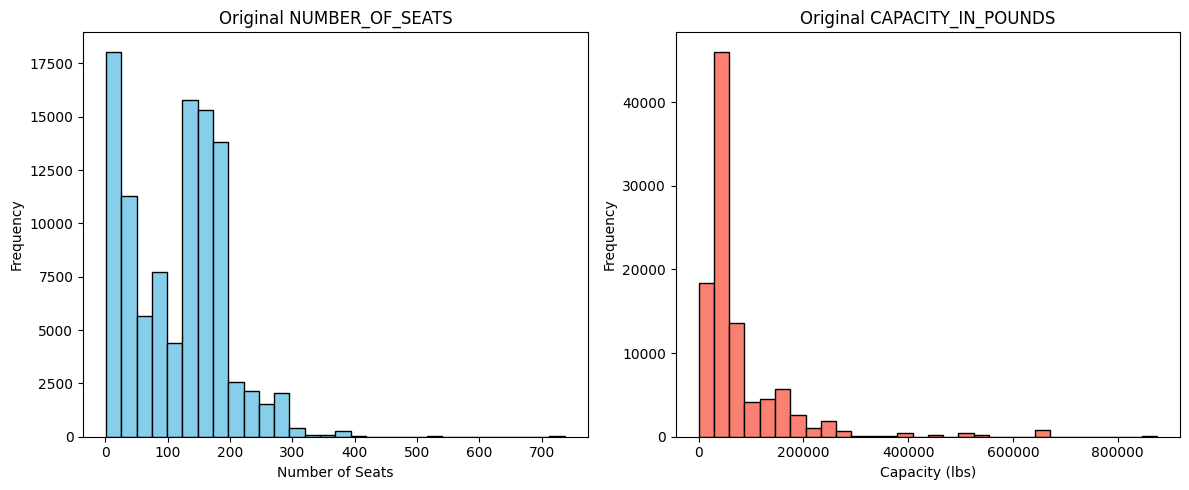

In [199]:
plot_original_histograms(cleaned_inventory)

In [200]:
def boxcox_transform(cleaned_inventory):
  # apply Box-Cox transformation
  cleaned_inventory["NUMBER_OF_SEATS_BOXCOX"], lambda_seats = boxcox(cleaned_inventory["NUMBER_OF_SEATS"])
  cleaned_inventory["CAPACITY_IN_POUNDS_BOXCOX"], lambda_capacity = boxcox(cleaned_inventory["CAPACITY_IN_POUNDS"])

  # histograms for transformed variables
  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  plt.hist(cleaned_inventory["NUMBER_OF_SEATS_BOXCOX"], bins=30, color='skyblue', edgecolor='black')
  plt.title("Box-Cox Transformed NUMBER_OF_SEATS")
  plt.xlabel("Transformed Seats")
  plt.ylabel("Frequency")

  plt.subplot(1,2,2)
  plt.hist(cleaned_inventory["CAPACITY_IN_POUNDS_BOXCOX"], bins=30, color='salmon', edgecolor='black')
  plt.title("Box-Cox Transformed CAPACITY_IN_POUNDS")
  plt.xlabel("Transformed Capacity")
  plt.ylabel("Frequency")

  plt.tight_layout()
  plt.show()

  return lambda_seats, lambda_capacity, cleaned_inventory

/tmp/ipython-input-3744460894.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipython-input-3744460894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


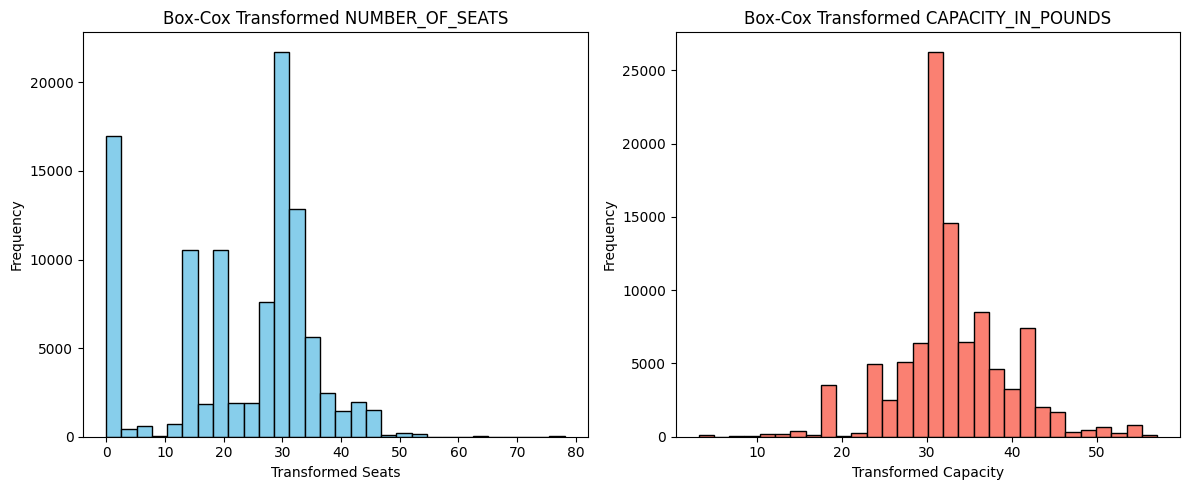

In [201]:
lambda_seats, lambda_capacity, cleaned_inventory_t = boxcox_transform(cleaned_inventory)

The transformed data is considerably closer to a normal distribution compared to the original data that had a heavy right skew. There is still a prominent peak at 1 (near zero) in the number of seats plot.

#### Problem 5

In [210]:
def analyze_by_size(cleaned_inventory):
  df = cleaned_inventory.copy()

  # Compute quartiles
  q1 = df["NUMBER_OF_SEATS"].quantile(0.25)
  q2 = df["NUMBER_OF_SEATS"].quantile(0.50)
  q3 = df["NUMBER_OF_SEATS"].quantile(0.75)

  # Assign SIZE
  def assign_size(seats):
     if seats < q1:
       return "SMALL"
     elif seats < q2:
       return "MEDIUM"
     elif seats < q3:
       return "LARGE"
     else:
       return "XLARGE"

  df["SIZE"] = df["NUMBER_OF_SEATS"].apply(assign_size)

  # Operating or not
  operating_counts = (
    df.assign(OPERATING=df["OPERATING_STATUS"] == "Y")
      .groupby("SIZE")["OPERATING"]
      .value_counts()
      .unstack(fill_value=0)
  )

  # print number of sizes in each status
  operating_counts.columns = ["NOT_OPERATING", "OPERATING"]

  print("\nAircraft counts by SIZE and operating status:")
  print(operating_counts)

  # plot
  operating_props = operating_counts.div(operating_counts.sum(axis=1), axis=0)

  operating_props.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
  )
  plt.ylabel("Proportion")
  plt.title("Operating vs Not Operating by Aircraft Size")
  plt.legend(title="Status")
  plt.tight_layout()
  plt.show()

  # aircraft status distribution
  aircraft_status_counts = (
    df.groupby("SIZE")["AIRCRAFT_STATUS"]
      .value_counts()
      .unstack(fill_value=0)
  )

  # print number of sizes in each aircraft status
  print("\nAircraft counts by SIZE and aircraft status:")
  print(aircraft_status_counts)

  # plot
  aircraft_status_props = aircraft_status_counts.div(
    aircraft_status_counts.sum(axis=1), axis=0
  )

  aircraft_status_props.plot(
    kind="bar",
    stacked=True,
    figsize=(9, 6)
  )
  plt.ylabel("Proportion")
  plt.title("Aircraft Status Distribution by Aircraft Size")
  plt.legend(title="Aircraft Status", bbox_to_anchor=(1.05, 1), loc="upper left")
  plt.tight_layout()
  plt.show()

  return df, operating_counts, operating_props, aircraft_status_counts, aircraft_status_props




Aircraft counts by SIZE and operating status:
        NOT_OPERATING  OPERATING
SIZE                            
LARGE             843      24483
MEDIUM           1619      29276
SMALL             606      19047
XLARGE            777      24625


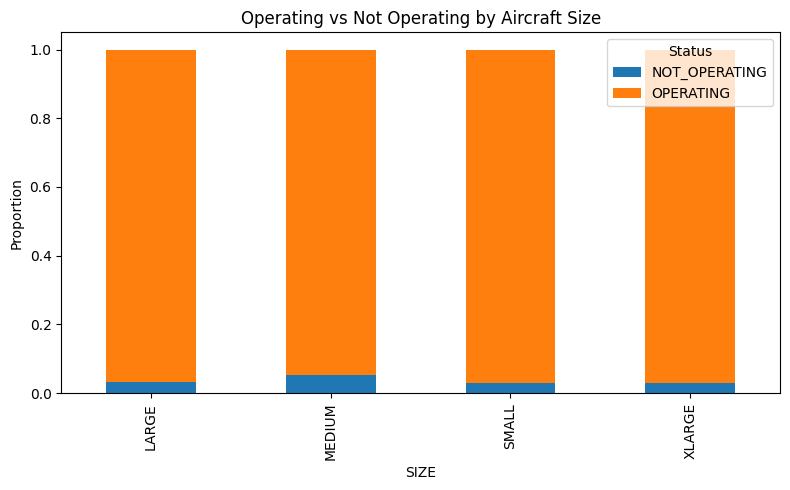


Aircraft counts by SIZE and aircraft status:
AIRCRAFT_STATUS     A      B   L      O
SIZE                                   
LARGE            2915   5093  44  17274
MEDIUM           2044  15856  34  12961
SMALL             741   4631   0  14281
XLARGE           1937   4923  44  18498


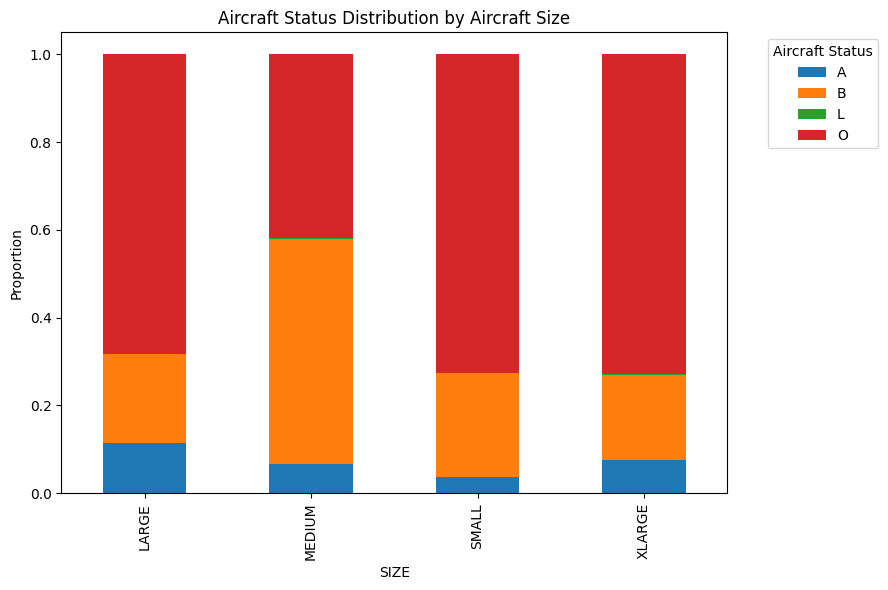

In [212]:
cleaned_inventory_size, operating_counts, operating_props, aircraft_status_counts, aircraft_status_props = analyze_by_size(cleaned_inventory_t)

Over 90% of all sizes are operating, with the highest proportion of not operating records in the MEDIUM size. SMALL, LARGE, and XLARGE all have around 60-70% operational aircraft status, with some banked and a smaller proportion with status A. Very few planes out of all the data have status L. MEDIUM planes have a much larger proportion of banked planes, while LARGE planes have the highest proportion of status A.

# Submission guidelines
Your submission should be contained in a `homework_1` folder of your Github repository, and it should include
- a `readme.md` file including how to run the code and what your expected outputs are (if the code is run),
- your source code, and
- a `.pdf` or `.html` file containing your written answers.

# Generative AI disclosure

*Syllabus* policy:

Required disclosure: each submission must include an AI Usage note stating: (1) tool(s) used, (2) the key prompt(s), and (3) what you changed and how you verified the results. If none, write: “AI Usage: None.”

1) Tool used: ChatGPT
2) Key prompts:
In question 2, I used AI to review regex for data cleaning and revise my regex lines to better reflect the data.
Prompt: Briefly review regex conventions and explain how I can remove specific instances of text at the beginning or end of words.

In question 1, I used AI to explain an error pointing at an internal line in sklearn when trying to use KNN.
Prompt: I got this error when I tried to run "knn_imputed = imputer.fit_transform(knn_features)" (also copied in the other frames of the error), explain why this is happening and how I can troubleshoot this.

3) What I changed:
Question 2: I took ChatGPT's feedback on correcting my regex lines and it helped me to clean the data more effectively (I was incorrectly defining word boundaries in the original regex). I verified this by running value_counts again.

Question 1: ChatGPT wasn't very helpful in addressing this one but I ended up restarting the runtime and importing sklearn again and it seemed to work fine.